In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import isolearn.io as isoio
import isolearn.keras as isol

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

#contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/pytorch_p36_fresh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/pytorch_p36_fresh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/pytorch_p36_fresh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [2]:
#Load DeeReCT-APA

from collections import defaultdict
from itertools import combinations
from itertools import chain
from collections import namedtuple
import pickle
import os.path
import shutil
import inspect 
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torch.utils.data

from pytorch_utils import *
from pas_utils import *

MODEL_DIR="../../../DeeReCT-APA-repo/pytorch_models"
PROCESSED_DIR="../../../DeeReCT-APA-repo/APA_ML/processed"

params={
    "batch_size":32,
    "lr":1e-3,
    "beta":1e-3,
    "net_type":"Multi-Conv-Net",    
    "conv1d_kernel_size":12,

    "conv1d_out_dim_1":40,
    "pool_size_1":3,
    "conv1d_out_dim_2":40,
    "pool_size_2":4,

    "linear1_dim":200,
    "seq_len":455,
    "lstm_output_size":100,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "parental_model_file":os.path.join(MODEL_DIR,"parental_model_bl-multi.pt"),
    "f1_model_file":os.path.join(MODEL_DIR,"f1_model_from_bl-multi.pt"),
    "dropout_rate":0.7,
    "fold":5
}

# create model
model=APAModel(params)
model.to(params["device"])

print("reload the best model and test")
model.load_state_dict(torch.load(params["parental_model_file"]))

def predict(logits, pas_numbers):
    for i in range(len(pas_numbers)):
        logits[i, pas_numbers[i]:] = -1e32
    softmax = F.softmax(logits, -1)
    return softmax

def model_predict(model, data_set, params, softmax=True, up_to_pas_number=1):
    with torch.no_grad():
        model.eval()
        #data_set.set_shuffle(False)
        predictions = []
        for local_batch, local_pas_numbers in data_set:
            local_batch = (local_batch).to(params["device"])
            local_pas_numbers = (local_pas_numbers).to(params["device"])
            local_outputs = model(local_batch, local_pas_numbers)
            if softmax:
                local_pred = predict(local_outputs, local_pas_numbers)
            else:
                local_pred = local_outputs
            for i in range(len(local_pas_numbers)):
                predictions += local_pred[i][:up_to_pas_number].tolist()

        predictions = np.array(predictions)
        return predictions


reload the best model and test


In [3]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [4]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : iso.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [5]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [6]:
#Define sequence template (APA Doubledope sublibrary)

#sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'
sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


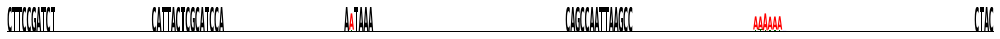

In [7]:
#Visualize background sequence distribution

save_figs = False

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name="benchmark_inclusion_" + dataset_name + "_background")


In [8]:
#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy

x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.6774233497383724


In [9]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9326065469402083


In [10]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [11]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [12]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 205
n_samples = 128
sample_mode = 'st'
#sample_mode = 'gumbel'

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)


In [13]:
#Build scrambler model
dummy_class = Input(shape=(1,), name='dummy_class')
input_logits = Input(shape=(1, seq_length, 4), name='input_logits')

pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask = sampler(dummy_class, input_logits)

scrambler_model = Model([input_logits, dummy_class], [pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.trainable = False
scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [14]:
scrambler_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dummy_class (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
background_dense (Embedding)    (None, 1, 820)       820         dummy_class[0][0]                
__________________________________________________________________________________________________
input_logits (InputLayer)       (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 205, 4)    0           background_dense[0][0]           
                                                                 template_dense[0][0]       

In [15]:

file_names = [
    "autoscrambler_dataset_apa_doubledope_sample_mode_st_n_samples_32_resnet_5_4_32_3_025_n_epochs_50_target_bits_025_deeper_resnet_importance_scores_test.npy",
    "perturbation_apa_doubledope_importance_scores_test.npy",
    "deepexplain_apa_doubledope_method_gradient_importance_scores_test.npy",
    "deeplift_apa_doubledope_method_guided_backprop_importance_scores_test.npy",
    "deepexplain_apa_doubledope_method_rescale_importance_scores_test.npy",
    #"deeplift_apa_doubledope_method_revealcancel_importance_scores_test.npy",
    "deepshap_apa_doubledope_importance_scores_test.npy",
    "deepexplain_apa_doubledope_method_integrated_gradients_importance_scores_test.npy",
    "extremal_apa_doubledope_mode_preserve_perturbation_blur_area_01_importance_scores_test.npy",
    "extremal_apa_doubledope_mode_preserve_perturbation_fade_area_01_importance_scores_test.npy",
    "pytorch_saliency_apa_doubledope_smaller_blur_importance_scores_test.npy",
    "sufficient_input_subsets_apa_doubledope_thresh_07_mean_importance_scores_test.npy",
    "autoscrambler_dataset_apa_doubledope_resnet_1_4_32_8_025_n_epochs_50_target_lum_005_gumbel_no_bg_lum_importance_scores_test.npy",
    "l2x_apa_doubledope_importance_scores_test.npy",
    "invase_apa_doubledope_conv_importance_scores_test.npy",
]

model_names =[
    "scrambler",
    "perturbation",
    "gradient",
    "guided_backprop",
    "deeplift",
    "deepshap",
    "integrated_gradients",
    "torchray_blur",
    "torchray_fade",
    "saliency_model",
    "sis_mean",
    "zero_scrambler",
    "l2x",
    "invase",
]

model_importance_scores_test = [np.load(file_name) for file_name in file_names]

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape[-1] > 1 :
        model_importance_scores_test[model_i] = np.sum(model_importance_scores_test[model_i], axis=-1, keepdims=True)


In [16]:

def dna_one_hot(s):
    encoding_dict = {'A': np.array([1.0,0.0,0.0,0.0]),
                     'T': np.array([0.0,1.0,0.0,0.0]),
                     'U': np.array([0.0,1.0,0.0,0.0]),
                     'C': np.array([0.0,0.0,1.0,0.0]),
                     'G': np.array([0.0,0.0,0.0,1.0]),
                     'N': np.array([0.25,0.25,0.25,0.25]),
                     'O': np.array([0.0,0.0,0.0,0.0])}
    try:
        np_arr=np.array(list(map(lambda c:encoding_dict[c],s)))
    except KeyError:
        print(s)
        raise
    return np_arr

def predict_for_seqs(model, seqs) :
    
    #Create sequence feature encodings of required shape
    
    x_test = []
    for seq in seqs :

        #up_pad = "TGAAAGATTCAAACAAGCTGCTCATTTTCATATCTGTAGTTACACATTCCATAGGAGCAAAGGGATTTGTGATCATCCATGAGCCATGATTGCATGTTACATTTTTCTGCCTCCATCTTATTTTTATGCTGATAGAAGCA"
        #dn_pad = "ACTCAAAGTGTTTCTAGGGGTTAAAAAGGTCCCATCCAGAGAGGATAGAGGCAGTGGTCTTCTGTCCCACCACCTGAGACCCTTGGCTACGTGAACTGATAAGTAAATGA"

        up_pad = "CTTTTGCCAGCTGCTAGGCAATGAAAGATTCAAACAAGCTGCTCATTTTCATATCTGTAGTTACACATTCCATAGGAGCAAAGGGATTTGTGATCATCCATGAGCCATGATTGCATGTTACATTTTTCTGCCTCCATCTTATTTTTATGCTGATAGAAGCA"
        dn_pad = "ACTCAAAGTGTTTCTAGGGGTTAAAAAGGTCCCATCCAGAGAGGATAGAGGCAGTGGTCTTCTGTCCCACCACCTGAGACCCTTGGCTACGTGAACTGATAAGTAAATGATATTTTACTTCATAAAGACTCATTCAACTTTTAGAAATTCTAGAAAATAATTCTTACTTGGATTAGGGTCTTCAGTGTGTACCATGAT"

        seq_prox = up_pad + seq[25:25+96] + dn_pad
        #seq_prox = up_pad[25:] + seq[:25+96] + dn_pad
        seq_dist = "CTTTTGCCAGCTGCTAGGCAATGAAAGATTCAAACAAGCTGCTCATGGTCATATCTGTAGTTACACATTCCATAGGAGCAAAGGGATTTGTGATCATCCATGAGCCATGATTGCATGTTACATTTTTCTGCCTCCATCTTAGGGTTATGCTGATAGAAGCACAGACTGGGTTACTAATATGGCTGAGGGCACTAGGTCTTAACACAATTAAAGGTCTAGGGTTATTAACTACCAGTGTGGGTTGCTTGCTGCACTCAAAGGGTTGCTAGGGGTTAACCAGGTCCCATCCAGAGAGGATAGAGGCAGTGGTCTTCTGTCCCACCACCTGAGACCCTTGGCTACGTGAACTGATAAGTAAATGATATTTTACTTCATAAAGACTCATTCAACTTTTAGAAATTCTAGAACCTAATTCTTACTTGGATTAGGGTCTTCAGTGTGTACCATGATGGTTT"

        x = np.concatenate([
            np.expand_dims(np.expand_dims(dna_one_hot(seq_prox), axis=0), axis=0),
            np.expand_dims(np.expand_dims(dna_one_hot(seq_dist), axis=0), axis=0)
        ], axis=1)

        x_test.append(x)

    x_test = np.concatenate(x_test, axis=0)

    n_signals = 2

    s_test = np.tile(np.array([n_signals], dtype=np.int), (x_test.shape[0],))

    data_set = [[
        torch.FloatTensor(x_test),
        torch.LongTensor(s_test)
    ]]
    
    y_pred = model_predict(model, data_set, params, softmax=True)
    
    return y_pred[:, None]

def predict_for_orig_onehots(model, encoder, onehots) :
    
    return predict_for_seqs(model, [encoder.decode(onehots[i, 0, :, :]) for i in range(onehots.shape[0])])


In [17]:
from scipy.stats import spearmanr

feature_quantiles = [0.90, 0.95]

on_state_logit_val = 50.

max_n_to_test = 384

encoder = isol.OneHotEncoder(205)

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

y_pred_ref = predict_for_orig_onehots(model, encoder, x_test)

r_ref = spearmanr(y_pred_ref, y_test[:, 0])[0]

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)

model_rs = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_rs = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
        
        importance_scores_test = None
        if model_names[model_i] not in ['zero_scrambler', 'l2x'] :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        else :
            importance_scores_test = model_importance_scores_test[model_i]
        
        n_to_test = min(importance_scores_test.shape[0] // batch_size * batch_size, max_n_to_test)
        importance_scores_test = importance_scores_test[:n_to_test]
        
        importance_scores_test *= np.expand_dims(np.max(pwm_mask[:n_to_test], axis=-1), axis=-1)

        quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

        top_logits_test = np.zeros(importance_scores_test.shape)
        top_logits_test[importance_scores_test > quantile_vals] = on_state_logit_val
        
        top_logits_test = np.tile(top_logits_test, (1, 1, 1, 4)) * x_test_logits[:n_to_test]

        _, _, samples_test, _, _ = scrambler_model.predict([top_logits_test, dummy_test[:n_to_test]], batch_size=batch_size)

        mean_preds = []
        for data_ix in range(samples_test.shape[0]) :

            if data_ix % 100 == 0 :
                print("Processing example " + str(data_ix) + "...")

            y_pred_var_mean = np.mean(predict_for_orig_onehots(model, encoder, samples_test[data_ix, ...])[:, 0])
            
            mean_preds.append(y_pred_var_mean)

        mean_preds = np.array(mean_preds)
        
        r_val = spearmanr(mean_preds, y_pred_ref[:n_to_test, 0])[0]
        
        feature_quantile_rs.append(r_val)

    model_rs.append(feature_quantile_rs)


Benchmarking model 'scrambler'...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Feature quantile = 0.95
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Benchmarking model 'perturbation'...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Feature quantile = 0.95
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Benchmarking model 'gradient'...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Feature quantile = 0.95
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Benchmarking model 'guided_backprop'...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Proc

In [18]:
model_names =[
    "scrambler",
    "perturbation",
    "gradient",
    "guided\nbackprop",
    "deeplift\nrescale",
    "deepshap",
    "integrated\ngradients",
    "torchray\nblur",
    "torchray\nfade",
    "saliency\nmodel",
    "sis\nmean",
    "zero\nscrambler",
    "l2x",
    "invase",
]

--- Spearman r Correlations ---
--------------------   REF    0.90   0.95
SCRAMBLER              0.49   0.73   0.66
PERTURBATION           0.49   0.60   0.57
GRADIENT               0.49   0.65   0.51
GUIDED BACKPROP        0.49   0.60   0.54
DEEPLIFT RESCALE       0.49   0.72   0.65
DEEPSHAP               0.49   0.71   0.63
INTEGRATED GRADIENTS   0.49   0.70   0.65
TORCHRAY BLUR          0.49   0.71   0.60
TORCHRAY FADE          0.49   0.68   0.58
SALIENCY MODEL         0.49   0.52   0.30
SIS MEAN               0.49   0.63   0.43
ZERO SCRAMBLER         0.49   0.61   0.49
L2X                    0.49   0.46   0.34
INVASE                 0.49   0.49   0.39


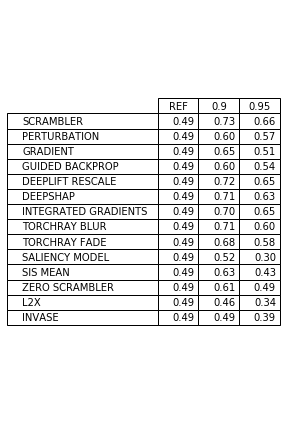

In [19]:
#Store benchmark results as tables

benchmark_name = "benchmark_inclusion_apa_doubledope_new_rescale_deerect_apa_deeper_resnet"

save_figs = True

r_table = np.zeros((len(model_rs), len(model_rs[0])))

for i, model_name in enumerate(model_names) :
    
    for j, feature_quantile in enumerate(feature_quantiles) :
        
        r_table[i, j] = model_rs[i][j]


#Plot and store r table
f = plt.figure(figsize = (2, 6))

cells = np.concatenate([np.array([r_ref] * r_table.shape[0]).reshape(-1, 1), r_table], axis=1)
cells = np.round(cells, 3).tolist()

print("--- Spearman r Correlations ---")
max_len = np.max([len(model_name.upper().replace("\n", " ")) for model_name in model_names])
print(("-" * max_len) + "   " + "   ".join([(str(feature_quantile) + "0")[:4] for feature_quantile in (["REF "] + feature_quantiles)]))
for i in range(len(cells)) :
    
    curr_len = len([model_name.upper().replace("\n", " ") for model_name in model_names][i])
    row_str = [model_name.upper().replace("\n", " ") for model_name in model_names][i] + (" " * (max_len - curr_len))
    
    for j in range(len(cells[i])) :
        cells[i][j] = (str(cells[i][j]) + "00000")[:4]
        
        row_str += "   " + cells[i][j]
    
    print(row_str)

table = plt.table(cellText=cells, rowLabels=[model_name.upper().replace("\n", " ") for model_name in model_names], colLabels=["REF"] + feature_quantiles, loc='center')

ax = plt.gca()
#f.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + "_r_table.png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + "_r_table.eps")

plt.show()
